In [127]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from tqdm import tqdm
import seaborn as sns

### Example of a very naive recommender system

Here, we explore a simple recommender based on friendly borrowing from [here](https://www.jillcates.com/pydata-workshop/html/tutorial.html) where also some variations and more efficient implementations are discussed.

As far as I understand recommender lingo this is an example of a collaborative filtering approach. Additionally it

 * is memory-based, i.e., similarity of users or items is computed from the user-item-interaction matrix to make predictions, not from a trained model. For instance, two items are similar if they have been similarly rated by many users. One problem with this approach is bad scaling for large datasets. Scaling can be improved using low rank matrix factorization (see blog post).

 * Alternatively, model-based approaches train a ML model based on the user-item-matrix, allowing for much better scalability. This is not explored here.

 * is item-based, i.e., recommendations are based on a given item (e.g., one that the user already likes) and then finding and recommending similar items. 
 
 * Alternatively, one could identify similar users, and then recommend something that those users like. This is called user-based cf and not explored here. 

In [91]:
# import transactions and article data
df_trans = pd.read_csv('../data/transactions_train.csv', parse_dates=[0], dtype={'article_id':'string'})
df_art = pd.read_csv('../data/articles.csv', dtype={'article_id':'string'})

In [92]:
# exclude parts of the data to reduce computational expense
# test period
df_trans = df_trans.query('t_dat <= "2020-09-15"')

# users with less than 5 items in history
n_items_per_user = df_trans.groupby('customer_id').count().article_id.rename('n_items')
df_trans['n_items'] = df_trans.customer_id.map(n_items_per_user)
df_trans = df_trans[df_trans.loc[:, 'n_items'] > 4]

# users that are not 100% online
n_items_per_channel = df_trans.groupby(['customer_id', 'sales_channel_id']).count().article_id
tmp1 = n_items_per_channel.reset_index().query('sales_channel_id == 1').set_index('customer_id').article_id.rename('offline_items')
tmp2 = n_items_per_channel.reset_index().query('sales_channel_id == 2').set_index('customer_id').article_id.rename('online_items')
online_fac = pd.concat([tmp1, tmp2], axis=1).fillna(0.0)
online_fac['online_fac'] = online_fac.online_items/(online_fac.online_items + online_fac.offline_items)
df.drop()


In [157]:
#tmp1 = online_fac.loc[online_fac.loc[:, 'online_fac'] == 1.0]
#print(len(tmp1))
df_trans['online_fac'] = df_trans.customer_id.map(online_fac.online_fac)
#df_trans[df_trans.loc[:, 'customer_id'] == tmp1]
df_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id,online_only,online_fac
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,1.0,1.000
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,1.0,1.000
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,NaN,0.975
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,NaN,0.975
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,NaN,0.975


In [173]:
print(len(df_trans.query('online_fac == 0.0')), len(df_trans.query('online_fac == 1.0')))

2218180 7818456


In [178]:
(df_trans.query('online_fac == 0.0').customer_id.nunique()+df_trans.query('online_fac == 1.0').customer_id.nunique())/df_trans.customer_id.nunique()

0.6452606729003246

In [189]:
df_trans.query('online_fac < 0.1').groupby('customer_id').count()

,t_dat,article_id,price,sales_channel_id,online_only,online_fac
customer_id,,,,,,
00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc,2,2,2,2,0,2
00008469a21b50b3d147c97135e25b4201a8c58997f78782a0cc706645e14493,4,4,4,4,0,4
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,15,15,15,15,0,15
00009c2aeae8761f738e4f937d9be6b49861a66339c2b1c3b1cc6e322729a370,5,5,5,5,0,5
0000ffa57a8098a6cd99c0f0782b3e674f47d68db69dc173c7e67e0f68170c4c,3,3,3,3,0,3
...,...,...,...,...,...,...
fffdf87d73dfab4ff56920a14c89e6cc929fda2a0619c93a4955dcc967f612e3,9,9,9,9,0,9
fffe61b99c2d0418ed22190a8490b142247e8897c67941ce25f78a99656e9f63,1,1,1,1,0,1
fffe8c175c550b9c7d994efcef320737723a43bedf360d7b7c5709cc232b1608,5,5,5,5,0,5


<AxesSubplot:xlabel='price', ylabel='count'>

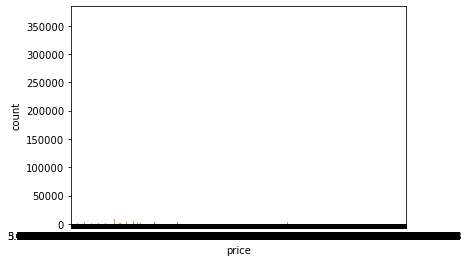

In [191]:
sns.countplot(x=df_trans.query('online_fac < 0.1').price)

<AxesSubplot:xlabel='online_fac', ylabel='online_fac'>

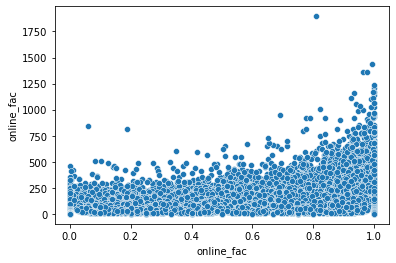

In [171]:
sns.scatterplot(x=online_fac.online_fac, y=df_trans.groupby('customer_id').count().online_fac)

In [162]:
df_trans.groupby('sales_channel_id').count()

,t_dat,customer_id,article_id,price,online_only,online_fac
sales_channel_id,,,,,,
1,9408462,9408462,9408462,9408462,0,9408462
2,22379862,22379862,22379862,22379862,7818456,22379862


In [22]:
# reduce data, WARNING: more than 100k samples will take ages!
df = df_trans.sample(100000, random_state=42)
# create new column filled with ones
df['rating'] = df['customer_id'].apply(lambda s: 1)
# now have rating be the number of times a customer bought an item
df = df.groupby(['customer_id', 'article_id']).sum()
df = df.drop(['price', 'sales_channel_id'], axis=1).reset_index()
# make sure ratings lie between 0 and 5 (very naive method)
#df['rating'] = df.rating.apply(lambda r: min(r, 5))

In [23]:
df.head()

,customer_id,article_id,rating
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0399061015,1
1,00007d2de826758b65a93dd24ce629ed66842531df6699...,0721257001,1
2,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,0612075001,1
3,0001ab2ebc1bb9a21d135e2fefdb11f12bee5c74ab2984...,0742947001,1
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0756582001,1


In [24]:
# create user-item-interaction matrix Y
# rows represent users, columns represent items
# note: users with no transactions and items never sold are not included
m = df.customer_id.nunique()
n = df.article_id.nunique()

# map between customer/article id and associated index
user_mapper = dict(zip(np.unique(df.customer_id), list(range(m))))
item_mapper = dict(zip(np.unique(df.article_id), list(range(n))))

user_inv_mapper = dict(zip(list(range(m)), np.unique(df.customer_id)))
item_inv_mapper = dict(zip(list(range(n)), np.unique(df.article_id)))

user_index = [user_mapper[i] for i in df.customer_id]
item_index = [item_mapper[i] for i in df.article_id]

# create sparse matrix
Y = csr_matrix((df.rating, (user_index, item_index)), shape=(m,n))


In [25]:
# check sparsity ratio
n_total = Y.shape[0]*Y.shape[1]
n_ratings = Y.nnz
sparsity = n_ratings/n_total
print('Matrix sparsity: ', round(sparsity*100, 2))

Matrix sparsity:  0.0


In [7]:
# mean normalization
n_ratings_per_item = Y.getnnz(axis=0)
sum_ratings_per_item = Y.sum(axis=0)
mean_rating_per_item = sum_ratings_per_item/n_ratings_per_item
# shape into matrix
Y_mean_item = np.tile(mean_rating_per_item, (Y.shape[0],1))
Y_norm = Y - csr_matrix(Y_mean_item)

In [35]:
def find_similar_items(article_id, Y, item_mapper, item_inv_mapper, k=12, metric='cosine'):
    Y = Y.T
    neighbour_ids = []

    item_ind = item_mapper[article_id]
    item_vec = Y[item_ind]
    if isinstance(item_vec, (np.ndarray)):
        item_vec = item_vec.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric, n_jobs=-1)
    kNN.fit(Y)
    neighbour = kNN.kneighbors(item_vec, return_distance=False)
    for i in range(0,k+1):
        n = neighbour.item(i)
        neighbour_ids.append(item_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [27]:
# pick any article
article_id = df.iloc[400].article_id
article_name = df_art.query('article_id == @article_id').prod_name.values[0]
print(article_name)

Everlacing Love Brief


In [28]:
# predict similar items based on user interactions
similar_items = find_similar_items(article_id, Y, item_mapper, item_inv_mapper)

In [29]:
similar_items

['0768551003',
 '0768486001',
 '0768503001',
 '0768545002',
 '0768545003',
 '0768551001',
 '0768470001',
 '0768591002',
 '0768632003',
 '0768632001',
 '0768632004',
 '0768465005']

In [30]:
item_names = dict(zip(df_art.article_id, df_art.prod_name))

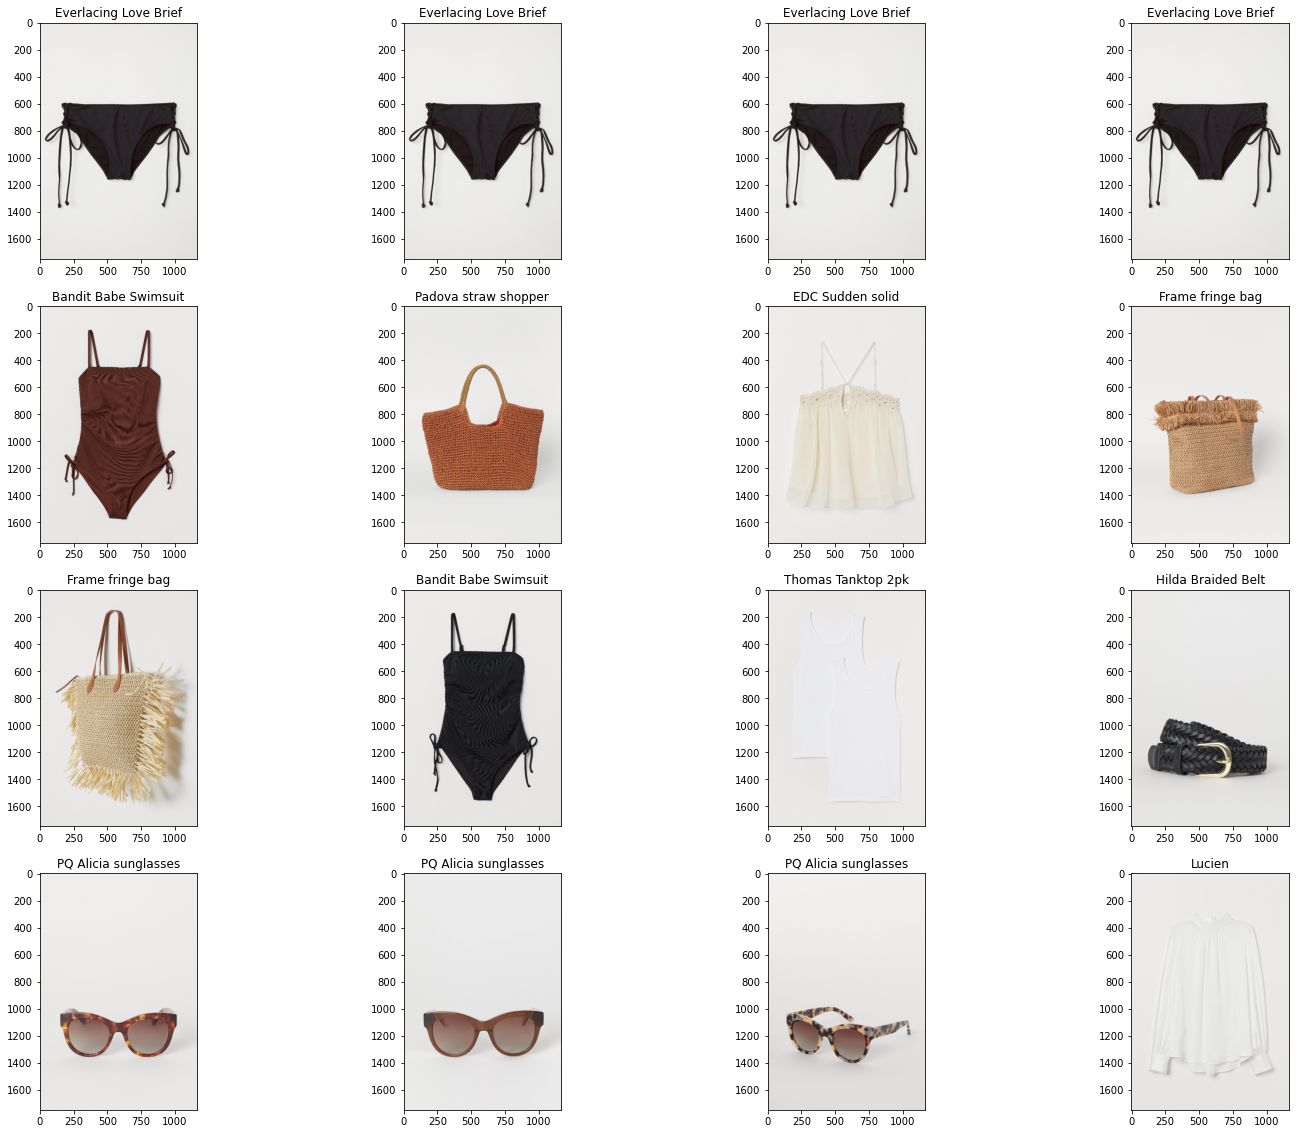

In [31]:
# display results
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
c = 0
for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        if i == 0:
            ax.set_title(article_name)
            fname = article_id + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
        else:
            fname = similar_items[c] + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('../data', 'images', subdir, fname)
            ax.set_title(item_names[similar_items[c]])
            c += 1
         
        if os.path.exists(full_path):
            img = mpimg.imread(full_path)
            ax.imshow(img)

In [41]:
predictable_items = df.article_id.unique()
all_items = df_art.article_id.unique()
unpredictable_items = np.setdiff1d(all_items, predictable_items)

In [39]:
rows = []
for item in tqdm(predictable_items):
    similar_items = find_similar_items(item, Y, item_mapper, item_inv_mapper)
    rows.append([item, ' '.join(similar_items)])
article_pred = pd.DataFrame(data=rows, columns=['article_id', 'prediction'])

100%|██████████| 34709/34709 [17:36<00:00, 32.85it/s]


In [40]:
article_pred.head()

,article_id,prediction
0,0399061015,0569984002 0768591002 0768503001 0768545002 07...
1,0721257001,0768551003 0768610001 0768503001 0768545002 07...
2,0612075001,0768610001 0768610004 0768545002 0768545003 07...
3,0742947001,0768591002 0768503001 0768545002 0768545003 07...
4,0756582001,0768591002 0768610002 0768503001 0768545002 07...


In [44]:
df_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [47]:
predictable_wardrobe = df_trans[df_trans.is_predictable].groupby('customer_id').article_id.agg(lambda s:' '.join(s))

AttributeError: 'DataFrame' object has no attribute 'is_predictable'

,0,1
0,1,2
1,3,4
